## Exploratory Data Analysis (EDA) & Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load dataset and analyse basic information
df_titanic = pd.read_csv("data.csv")
print("Shape of the dataset:", df_titanic.shape)
print("Data types:\n", df_titanic.dtypes)
print("First 25 rows of the dataset:\n", df_titanic.head(25))
print("Missing values:\n", df_titanic.isnull().sum())

Shape of the dataset: (891, 12)
Data types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
First 25 rows of the dataset:
     PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   
11           12         1       1   
12           13         0       3   
13           14         0       3   
14           15         0       3   
15           16         1       2   
16   

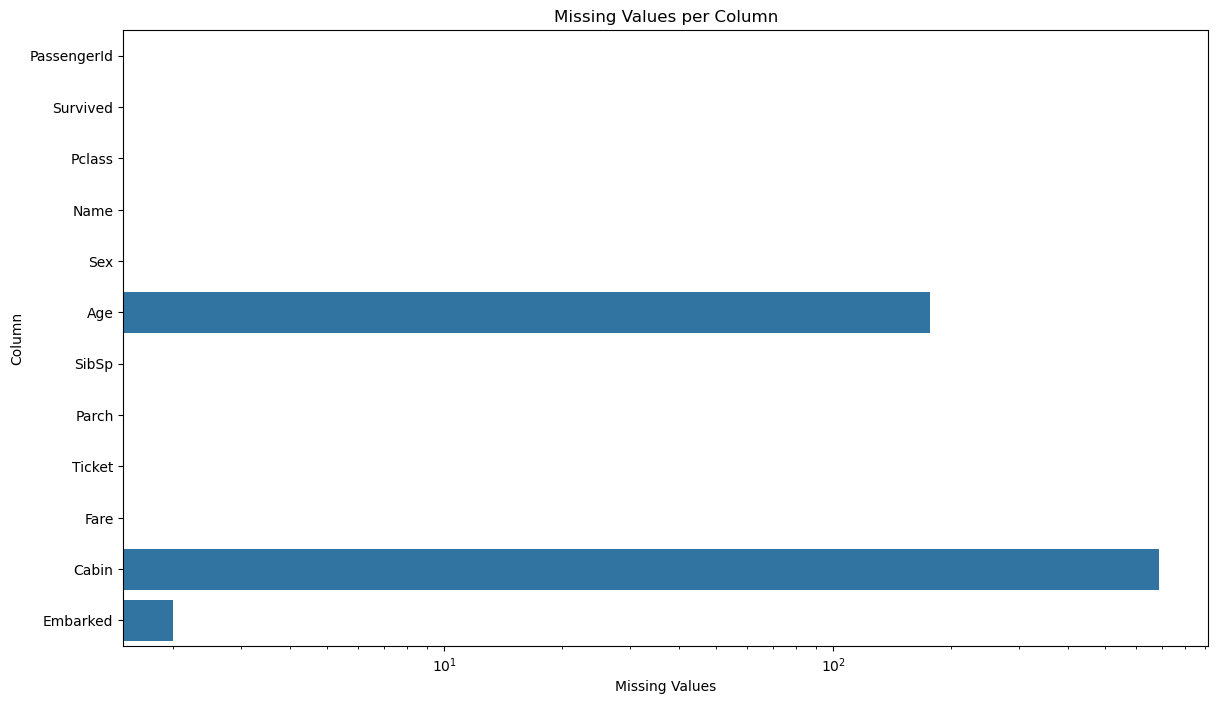

In [9]:
# Plot the missing values
plt.figure(figsize=(14, 8))
missing_values = df_titanic.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']
sns.barplot(x='Missing Values', y='Column', data=missing_values)
plt.xscale('log')
plt.title('Missing Values per Column')
plt.show()

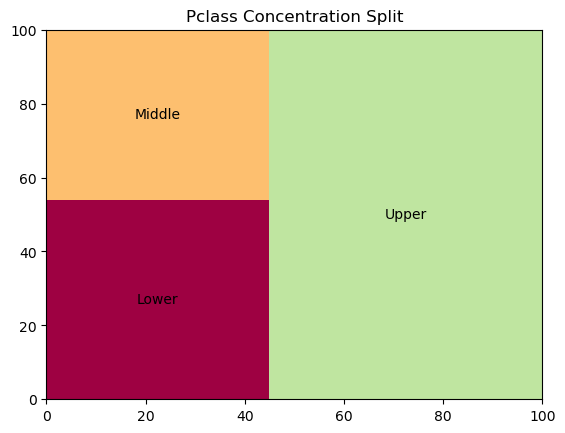

In [10]:
# This visualizes the distribution of passenger classes (Pclass) in the dataset
df = df_titanic.groupby('Pclass').size().reset_index(name='counts')
labels = ['Lower', 'Middle', 'Upper']
sizes = df['counts'].values.tolist()
colors = [plt.cm.Spectral(i / float(len(labels))) for i in range(len(labels))]
squarify.plot(sizes=sizes, label=labels, color=colors)
plt.title('Pclass Concentration Split')
plt.show()

In [13]:
# extracting titles
df_titanic['Name'] = df_titanic['Name'].apply(lambda x: re.search(r'(Countess|Mme|Mrs|Mr|Mlle|Miss|Ms|Master|Dr|Rev|Col|Major|Capt)', x))
df_titanic['Name'] = df_titanic['Name'].apply(lambda x: x.group() if x else 'Others')

### Handle missing values

In [14]:
print("Embarked column before imputation:\n", df_titanic['Embarked'].value_counts(dropna=False))
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_titanic['Embarked'] = si.fit_transform(df_titanic[['Embarked']]).ravel()
print("Value counts for 'Embarked' after imputation:\n", df_titanic['Embarked'].value_counts())

Embarked column before imputation:
 Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
Value counts for 'Embarked' after imputation:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [15]:
df_titanic['Cabin'] = df_titanic['Cabin'].str[0:1]
df_titanic['Cabin'].fillna('U', inplace=True)
print("Value counts for 'Cabin':\n", df_titanic['Cabin'].value_counts())

Value counts for 'Cabin':
 Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


In [16]:
numeric_columns = ['Age', 'Fare']
imputer = SimpleImputer(strategy='mean')
df_titanic[numeric_columns] = imputer.fit_transform(df_titanic[numeric_columns])
df_titanic['Age'] = np.round(df_titanic['Age'], 1)


# Feature engineering

In [17]:
# Create 'familyMembers' feature
# This creates a new feature representing the total number of family members aboard
df_titanic['familyMembers'] = df_titanic['Parch'] + df_titanic['SibSp']

# Create 'farePerFamily' feature
# This calculates the fare per family member
df_titanic['farePerFamily'] = df_titanic['Fare'] / (df_titanic['familyMembers'] + 1)

# Extract ticket information
# This categorizes tickets into 'Type 1' and 'Type 2' 
df_titanic['ticketInfo'] = df_titanic['Ticket'].apply(lambda x: 'Type 1' if re.search(r'\d', x) is None else 'Type 2')
print("Value counts for 'ticketInfo':\n", df_titanic['ticketInfo'].value_counts())

# Create age bins
# This bins the 'Age' feature into 4 categories
df_titanic['ageBins'] = pd.qcut(df_titanic['Age'], q=4, labels=[0, 1, 2, 3])


Value counts for 'ticketInfo':
 ticketInfo
Type 2    887
Type 1      4
Name: count, dtype: int64


## Label Encoding of Categorical Columns

In [18]:
categorical_columns = ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'familyMembers', 'ticketInfo', 'Cabin']
df_titanic_cat = df_titanic[categorical_columns]
le = LabelEncoder()
for col in df_titanic_cat.columns:
    df_titanic_cat[col] = le.fit_transform(df_titanic_cat[col])
df_titanic.drop(columns=categorical_columns, inplace=True)
df_titanic = pd.concat([df_titanic, df_titanic_cat], axis=1)


## Standard Scaling on Numerical Columns

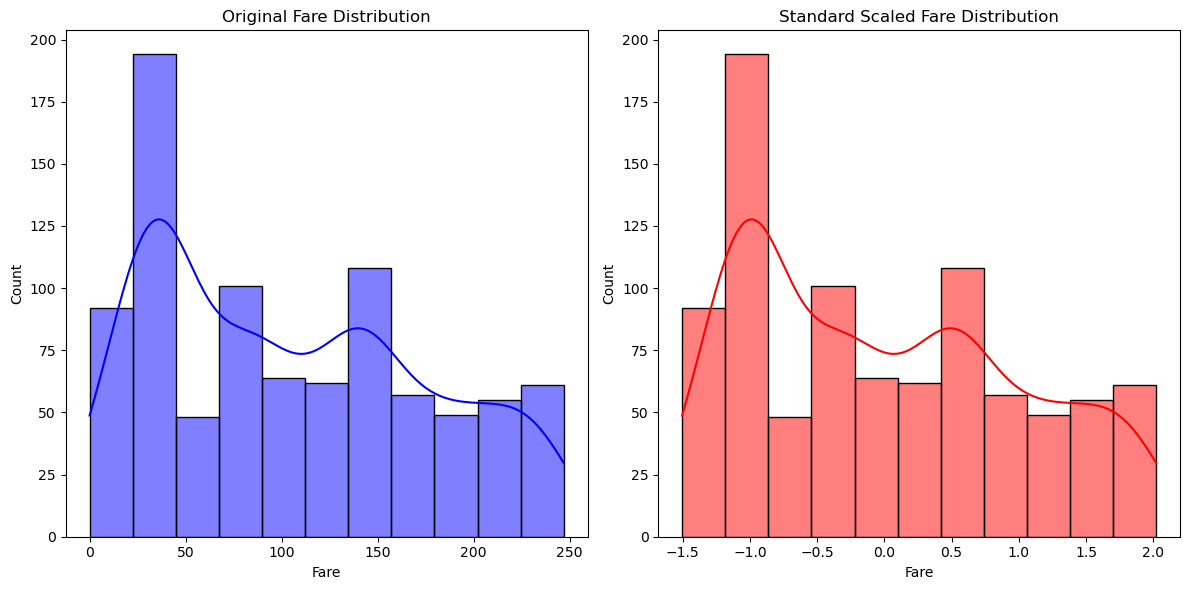

In [19]:
num_columns = ['Fare', 'farePerFamily']
scaler = StandardScaler()
df_titanic[num_columns] = scaler.fit_transform(df_titanic[num_columns])

plt.figure(figsize=(12, 6))

# Original Fare Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_titanic['Fare'] * scaler.scale_[0] + scaler.mean_[0], kde=True, color='blue')
plt.title('Original Fare Distribution')

# Standard Scaled Fare Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_titanic['Fare'], kde=True, color='red')
plt.title('Standard Scaled Fare Distribution')

plt.tight_layout()
plt.show()
